<h1>⚠️ DO NOT RUN THIS NOTEBOOK
Models are already trained and deployed.


<h1>Importing Libraries 
Creating new file for better redeablity


In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import xgboost as xgb


<h1>Reading Data from new csv file which we have created in the previous file 


In [ ]:
df=pd.read_csv('dataset/top_10_sales_data.csv')
df['sales_date']=pd.to_datetime(df['sales_date'])
df.head()

,sales_date,product_id,quantity,total_price,employee_id,customer_id,month,year,days_of_week
0,2023-01-01,437,5,10.0,138,82477,1,2023,Sunday
1,2023-01-01,437,3,6.0,26,46458,1,2023,Sunday
2,2023-01-01,298,6,39.6,7,48576,1,2023,Sunday
3,2023-01-01,120,1,16.9,236,48803,1,2023,Sunday
4,2023-01-01,448,3,57.6,9,95087,1,2023,Sunday


<h1>Aggregating the code on Daily basis

In [20]:
# Aggregating Data to Daily/Product Level 
# Group by sales_date and product_id, summing quantity and price.
# We keep month, year, and days_of_week for later feature engineering.
df = df.groupby(['sales_date', 'product_id']).agg(
    quantity=('quantity', 'sum'),
    total_price=('total_price', 'sum'),
    month=('month', 'max'), 
    year=('year', 'max'),
    days_of_week=('days_of_week', 'first')
).reset_index()

# Set 'sales_date' as index for time-series operations later
df['sales_date'] = pd.to_datetime(df['sales_date'])
df.set_index('sales_date', inplace=True)
df.head()

,product_id,quantity,total_price,month,year,days_of_week
sales_date,,,,,,
2023-01-01,20,149,1430.4,1,2023,Sunday
2023-01-01,120,90,1521.0,1,2023,Sunday
2023-01-01,150,168,1276.8,1,2023,Sunday
2023-01-01,153,254,965.2,1,2023,Sunday
2023-01-01,165,391,938.4,1,2023,Sunday


<h3>Fixng variable name for consistency

In [21]:
# Renaming for consistency
if 'days_of_week' in df.columns:
    df.rename(columns={'days_of_week': 'day_of_week'}, inplace=True)
elif 'day_of_week' not in df.columns:
    df['day_of_week'] = df.index.day_name()

<h3>Finding season Sales pattern in the data  We can see in the graph below that the sales during the end of the year is more compared to the rest of the year so found out a pattern in it

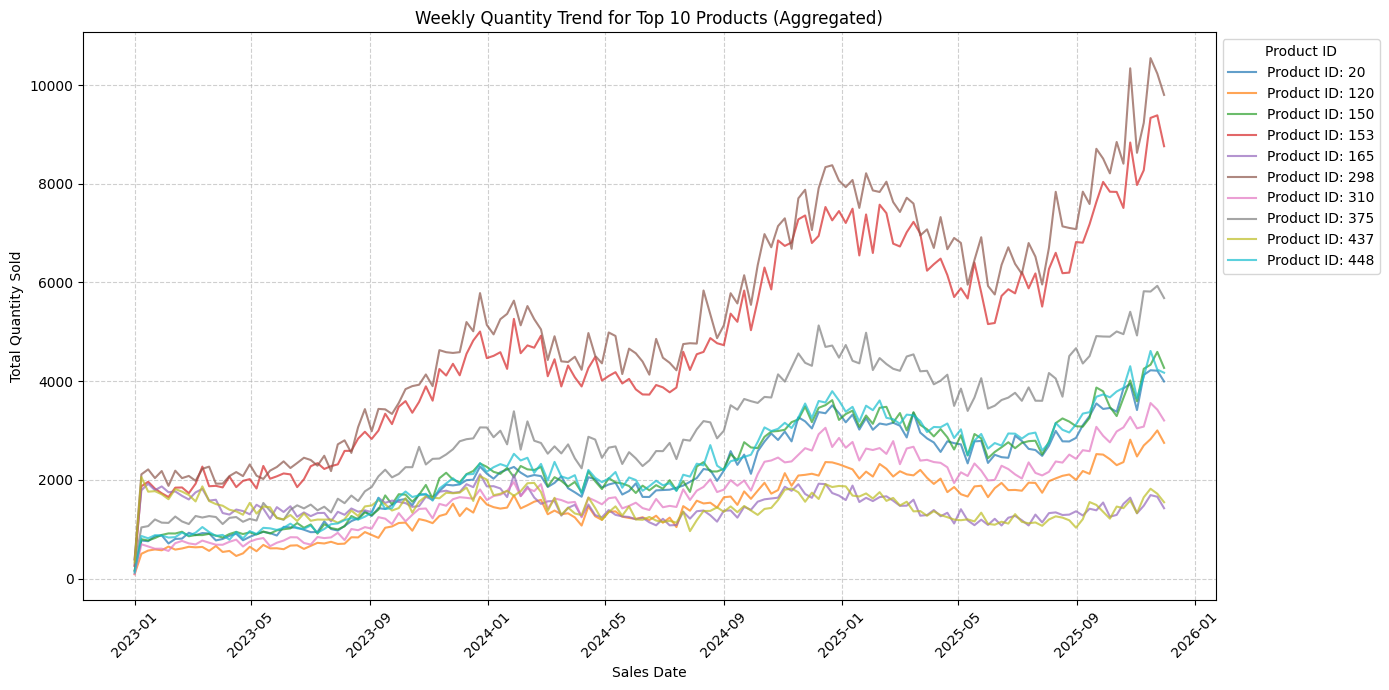

In [22]:
# Visualizing Weekly Trend for Top 10 Products
weekly_trend = df.groupby('product_id').resample('W')['quantity'].sum().reset_index()

plt.figure(figsize=(14, 7))
top_10_ids = df['product_id'].unique()

for product_id in top_10_ids:
    product_data = weekly_trend[weekly_trend['product_id'] == product_id]
    plt.plot(product_data['sales_date'], product_data['quantity'], label=f'Product ID: {product_id}', alpha=0.7)

plt.title('Weekly Quantity Trend for Top 10 Products (Aggregated)')
plt.xlabel('Sales Date')
plt.ylabel('Total Quantity Sold')
plt.legend(title='Product ID', loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<h3>Finding pattern in data weekly ,if there is a more sales on weekend  

CONCLUSION - Found increase sales on weekend

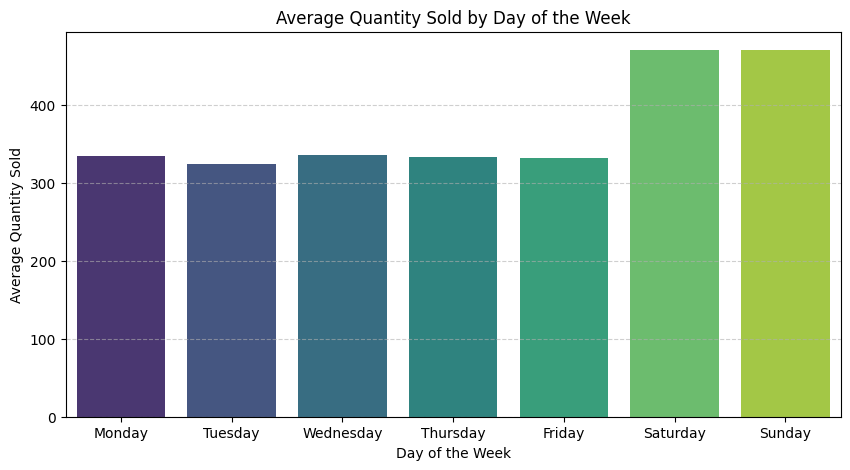

In [23]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_avg_quantity = df.groupby('day_of_week')['quantity'].mean().reindex(day_order).reset_index()
day_avg_quantity.rename(columns={'quantity': 'average_quantity_sold'}, inplace=True)

plt.figure(figsize=(10, 5))
sns.barplot(x='day_of_week', y='average_quantity_sold', data=day_avg_quantity, hue='day_of_week', palette='viridis', legend=False)

plt.title('Average Quantity Sold by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Quantity Sold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

<h1>Checking for outliers using box plot

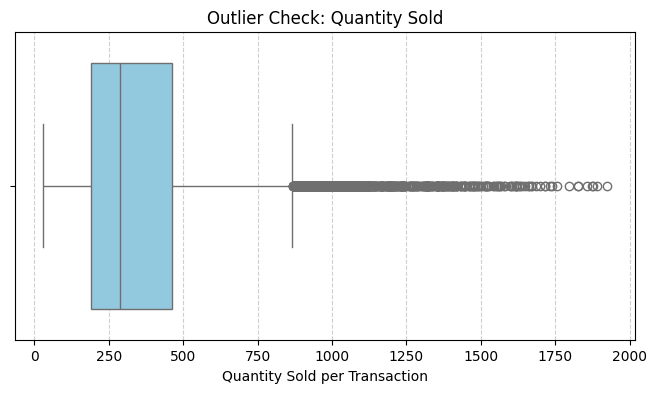

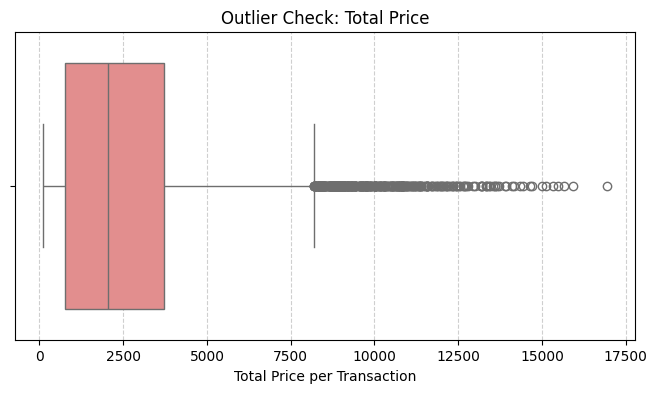

In [24]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['quantity'], color='skyblue') 
plt.title('Outlier Check: Quantity Sold')
plt.xlabel('Quantity Sold per Transaction')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x=df['total_price'], color='lightcoral')
plt.title('Outlier Check: Total Price')
plt.xlabel('Total Price per Transaction')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()

<h1>Handling Outliers using IQR

In [25]:
# creating new col unit price as we do not have feature for price of one unit
df['unit_price'] = df['total_price'] / df['quantity']
def cap_outliers_iqr(df, column, factor=1.5): # using standard IQR factor of 1.5 
    # Calculate IQR, Q1, and Q3
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1 # finding middle data spread
    
    # cal upper and lower bounds
    upper_bound = Q3 + factor * IQR
    lower_bound = Q1 - factor * IQR
    # replacing outliers by their bounds 
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    df[column] = np.where(df[column] < lower_bound, np.maximum(0, lower_bound), df[column])
    return df

df = cap_outliers_iqr(df, 'quantity')
df = cap_outliers_iqr(df, 'total_price')
df = cap_outliers_iqr(df, 'unit_price')

print("Data after Outlier Capping and Unit Price calculation:")
print(df[['quantity', 'total_price', 'unit_price']].describe().T)

Data after Outlier Capping and Unit Price calculation:
               count         mean          std    min    25%      50%     75%  \
quantity     10650.0   355.109953   220.583945   29.0  191.0   287.00   461.0   
total_price  10650.0  2593.124629  2154.265717  106.0  758.4  2044.80  3729.0   
unit_price   10650.0     7.770000     5.734910    2.0    2.4     7.05     9.6   

                max  
quantity      866.0  
total_price  8184.9  
unit_price     19.2  


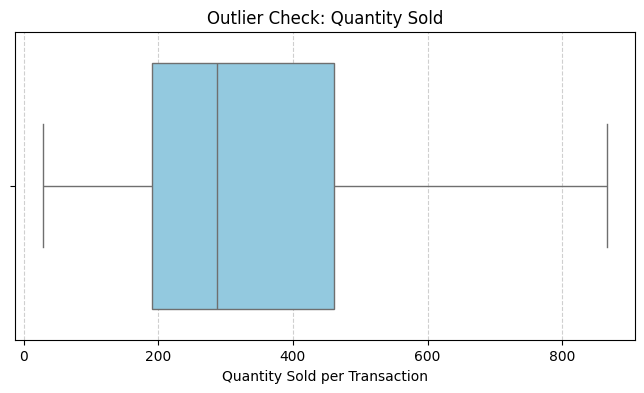

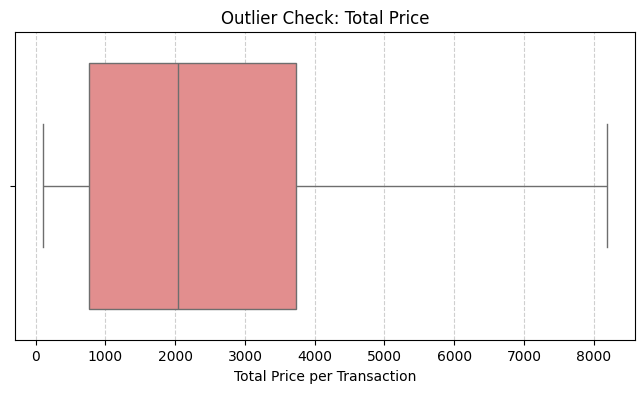

In [26]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['quantity'], color='skyblue') 
plt.title('Outlier Check: Quantity Sold')
plt.xlabel('Quantity Sold per Transaction')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x=df['total_price'], color='lightcoral')
plt.title('Outlier Check: Total Price')
plt.xlabel('Total Price per Transaction')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()

In [27]:
df.sort_values(by=['sales_date', 'product_id'], inplace=True)
print(df.head())

            product_id  quantity  total_price  month  year day_of_week  \
sales_date                                                               
2023-01-01          20     149.0       1430.4      1  2023      Sunday   
2023-01-01         120      90.0       1521.0      1  2023      Sunday   
2023-01-01         150     168.0       1276.8      1  2023      Sunday   
2023-01-01         153     254.0        965.2      1  2023      Sunday   
2023-01-01         165     391.0        938.4      1  2023      Sunday   

            unit_price  
sales_date              
2023-01-01         9.6  
2023-01-01        16.9  
2023-01-01         7.6  
2023-01-01         3.8  
2023-01-01         2.4  


<h1>Creating Lag features 

In [28]:
df['qty_lag_1']=df.groupby('product_id')['quantity'].shift(1)
df['qty_lag_7']=df.groupby('product_id')['quantity'].shift(7)
df['qty_lag_52_wks']=df.groupby('product_id')['quantity'].shift(364)

<h3>Lag features created null data for the starting or the initial data from which older data was not present 

In [29]:
df.dropna(inplace=True)
df.shape[0]

7010

<h1>Creating Time based Features 

In [30]:
df['day_of_week_num']=df.index.dayofweek # Monday=0, Sunday=6
df['day_of_year']=df.index.dayofyear # 1 to 365/366
df['week_of_year']=df.index.isocalendar().week.astype(int) # week number of the year like 1 to 52
df['quater']=df.index.quarter # 1 to 4 

<h1>Creating Rolling avg Features

In [31]:
df.reset_index(inplace=True) # removing sales date as index for rolling calculations
df['qty_roll_avg_7'] = df.groupby('product_id')['quantity'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean().shift(1))
df['qty_roll_avg_30'] = df.groupby('product_id')['quantity'].transform(
    lambda x: x.rolling(window=30, min_periods=1).mean().shift(1))
df.set_index('sales_date', inplace=True) # set index back to sales_date
df.dropna(inplace=True) # removing nan values genreated due to rolling calculations like first 7 or 30 days

<h1>Performing label encoding to convert categorical values into numerical

In [32]:
categorical_cols = ['product_id'] 
le = LabelEncoder()

# We need 'product_id' as a non-index column for the loop, so we reset/set index around it
df.reset_index(inplace=True)

for col in categorical_cols:
    # Ensure product_id is a column and encoded
    df[col] = df[col].astype('category')
    df[col + '_encoded'] = le.fit_transform(df[col])
    
# Re-set index and drop the non-encoded product_id column
df.set_index('sales_date', inplace=True)
df.drop(columns=categorical_cols, inplace=True)
df.drop(columns=['day_of_week'], inplace=True) # Dropping the day name column as we use day_of_week_num
df.head()

,quantity,total_price,month,year,unit_price,qty_lag_1,qty_lag_7,qty_lag_52_wks,day_of_week_num,day_of_year,week_of_year,quater,qty_roll_avg_7,qty_roll_avg_30,product_id_encoded
sales_date,,,,,,,,,,,,,,,
2024-01-01,259.0,2486.4,1,2024,9.6,338.0,242.0,107.0,0,1,1,1,338.0,338.0,0
2024-01-01,198.0,3346.2,1,2024,16.9,251.0,167.0,58.0,0,1,1,1,251.0,251.0,1
2024-01-01,280.0,2128.0,1,2024,7.6,345.0,306.0,114.0,0,1,1,1,345.0,345.0,2
2024-01-01,585.0,2223.0,1,2024,3.8,704.0,482.0,166.0,0,1,1,1,704.0,704.0,3
2024-01-01,296.0,710.4,1,2024,2.4,256.0,258.0,214.0,0,1,1,1,256.0,256.0,4


<h1>Splitting the data into 3 parts --

<h3>Train - Contains data from start to 2025-10

Validation - Contains data of 4 weeks bw training and testing 

Testing - Contains data of last 4 weeks


In [33]:
end_of_data=df.index.max()
weeks_in_test=4
test_start_date = end_of_data - timedelta(days=weeks_in_test * 7) # timedelta helps to find time differences bw dates
weeks_in_validation = 4
validation_start_date = test_start_date - timedelta(days=weeks_in_validation * 7)
df_train = df[df.index < validation_start_date].copy() # used for fixing pandas setting with copy warning
df_validation = df[(df.index >= validation_start_date) & (df.index < test_start_date)].copy()
df_test = df[df.index >= test_start_date].copy()

<h2>Scaling Features bw the range of 0-1 so that data is in same range throught the dataset

In [34]:
features_to_scale=['total_price','qty_lag_1','qty_lag_7','qty_lag_52_wks','qty_roll_avg_7','qty_roll_avg_30']
scaler=MinMaxScaler()
scaler.fit(df_train[features_to_scale])

qty_scaler=MinMaxScaler()
qty_scaler.fit(df_train[['quantity']])

df_train[features_to_scale] = scaler.transform(df_train[features_to_scale])
df_validation[features_to_scale] = scaler.transform(df_validation[features_to_scale])
df_test[features_to_scale] = scaler.transform(df_test[features_to_scale])

df_train['quantity'] = qty_scaler.transform(df_train[['quantity']])
df_validation['quantity'] = qty_scaler.transform(df_validation[['quantity']])
df_test['quantity'] = qty_scaler.transform(df_test[['quantity']])
print(df_train[['quantity'] + features_to_scale].head())

            quantity  total_price  qty_lag_1  qty_lag_7  qty_lag_52_wks  \
sales_date                                                                
2024-01-01  0.253383     0.294644   0.350554   0.232472        0.093190   
2024-01-01  0.178352     0.401069   0.243542   0.140221        0.034648   
2024-01-01  0.279213     0.250282   0.359164   0.311193        0.101553   
2024-01-01  0.654367     0.262041   0.800738   0.527675        0.163680   
2024-01-01  0.298893     0.074812   0.249692   0.252153        0.221027   

            qty_roll_avg_7  qty_roll_avg_30  
sales_date                                   
2024-01-01        0.279813         0.255674  
2024-01-01        0.161146         0.133029  
2024-01-01        0.289361         0.265542  
2024-01-01        0.779034         0.771627  
2024-01-01        0.167966         0.140078  


<h1>Model Selection

<h5>Simple Linear Regression - It is a type of model that works by ploting a stright line bw all the points 

it assumes the relation is linear and simple

increase in x so increase in y

<h5>MAE tells us how much our predictions are wrong on average.
It simply looks at the difference between actual and predicted values, takes the absolute value (ignores plus/minus), and finds the average.

RMSE also measures error, but it gives more punishment to bigger mistakes.
It squares the errors (so big errors grow a lot), averages them, and then takes the square root.

MAPE tells us the error in percentage form.
It checks how far predictions were from actual values, relative to the actual value.

In [35]:
# defining target and feature columns
TARGET_COL = 'quantity'
FEATURE_COLS = [
    'unit_price',
    'qty_lag_1', 'qty_lag_7', 'qty_lag_52_wks',
    'qty_roll_avg_7', 'qty_roll_avg_30',
    'day_of_week_num', 'day_of_year', 'week_of_year',
    'quater',
    'product_id_encoded'
]

# MAPE function
def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))) # avoid division by zero 


# creating empty dict for storing results
slr_results = {}
product_ids = df_train['product_id_encoded'].unique()

for product_id_encoded in product_ids:
    # Filter data for the current product
    train_data = df_train[df_train['product_id_encoded'] == product_id_encoded]
    valid_data = df_validation[df_validation['product_id_encoded'] == product_id_encoded]
    
    # Features and Target
    X_train = train_data[FEATURE_COLS]
    y_train = train_data[TARGET_COL]
    
    # Train Linear Regression
    model = LinearRegression() # parameters can be tuned later | like fit_intercept,n_jobs
    model.fit(X_train, y_train)
    
    # Predict
    y_pred_valid = model.predict(valid_data[FEATURE_COLS])
    
    # Metrics
    rmse = np.sqrt(mean_squared_error(valid_data[TARGET_COL], y_pred_valid))
    mae = mean_absolute_error(valid_data[TARGET_COL], y_pred_valid)
    mape_val = mape(valid_data[TARGET_COL], y_pred_valid)
    
    # Store the results
    slr_results[product_id_encoded] = {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape_val
    }

    print(f"Product {product_id_encoded}: RMSE={rmse:.4f}, MAPE={mape_val*100:.2f}%")


# Final Metric Lists
all_rmses_slr = [res['RMSE'] for res in slr_results.values()]
all_maes_slr  = [res['MAE'] for res in slr_results.values()]
all_mapes_slr = [res['MAPE'] for res in slr_results.values()]

print("\n SIMPLE LINEAR REGRESSION | Total Metric Accros Products")
print(f"RMSE (Error Penalty): {np.mean(all_rmses_slr):.2f} units")
print(f"MAE (Average Error):  {np.mean(all_maes_slr):.2f} units")
print(f"MAPE (Percentage Error): {np.mean(all_mapes_slr) * 100:.2f}%")


Product 0: RMSE=0.0995, MAPE=15.84%
Product 1: RMSE=0.0758, MAPE=17.94%
Product 2: RMSE=0.1171, MAPE=17.59%
Product 3: RMSE=0.0482, MAPE=3.93%
Product 4: RMSE=0.0695, MAPE=42.86%
Product 5: RMSE=0.0440, MAPE=3.56%
Product 6: RMSE=0.0844, MAPE=14.52%
Product 7: RMSE=0.1191, MAPE=13.05%
Product 8: RMSE=0.0690, MAPE=43.83%
Product 9: RMSE=0.1072, MAPE=15.10%

 SIMPLE LINEAR REGRESSION | Total Metric Accros Products
RMSE (Error Penalty): 0.08 units
MAE (Average Error):  0.07 units
MAPE (Percentage Error): 18.82%


 <h3>In the above ouput product 4 and 8 have very small quantites sold that why insipte of very less error there mape is very high
 

<h5>XGB Model - it is like a small group of tress 

that works by correcting the mistakes of the previous one so gradually improving its performance 

In [36]:
# defining target and feature columns for XGBoost 
TARGET_COL = 'quantity'
FEATURE_COLS = [
    'unit_price','qty_lag_1',
    'qty_lag_7', 'qty_lag_52_wks',
    'qty_roll_avg_7', 'qty_roll_avg_30',
    'day_of_week_num', 'day_of_year', 'week_of_year',
    'quater',
    'product_id_encoded'
]

# MAPE function
def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true)))

# Train and Evaluate 10 Separate XGBoost Models 
xgb_models = {} 
xgb_results = {}
product_ids = df_train['product_id_encoded'].unique()

for product_id_encoded in product_ids:
    train_data = df_train[df_train['product_id_encoded'] == product_id_encoded]
    valid_data = df_validation[df_validation['product_id_encoded'] == product_id_encoded]
    
    X_train = train_data[FEATURE_COLS]
    y_train = train_data[TARGET_COL]
    
    # XGBoost Regressor
    model = xgb.XGBRegressor(
        objective='reg:squarederror',# regression with squared loss | type of problem 
        n_estimators=100,# number of tress
        learning_rate=0.1,#speed of learning
        random_state=42, # reproduciblity | use the same random choice every time
        n_jobs=-1 # no of cpu cores
    )
    
    model.fit(X_train, y_train)
    
    # Predict
    y_pred_valid = model.predict(valid_data[FEATURE_COLS])
    
    # Errors
    rmse = np.sqrt(mean_squared_error(valid_data[TARGET_COL], y_pred_valid))
    mae = mean_absolute_error(valid_data[TARGET_COL], y_pred_valid)
    mape_val = mape(valid_data[TARGET_COL], y_pred_valid)
    
    xgb_results[product_id_encoded] = {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape_val
    }

    if product_id_encoded == product_ids[0]:
        xgb_models['first_model'] = model

    print(f"Product {product_id_encoded}: RMSE={rmse:.4f}, MAPE={mape_val*100:.2f}%")

# Collect lists
all_rmses_xgb = [res['RMSE'] for res in xgb_results.values()]
all_maes_xgb  = [res['MAE'] for res in xgb_results.values()]
all_mapes_xgb = [res['MAPE'] for res in xgb_results.values()]


print("\n XGBOOST REGRESSOR | Total Metric Accros Products")
print(f"RMSE (Error Penalty): {np.mean(all_rmses_xgb):.2f} units")
print(f"MAE (Average Error):  {np.mean(all_maes_xgb):.2f} units")
print(f"MAPE (Percentage Error): {np.mean(all_mapes_xgb) * 100:.2f}%")


Product 0: RMSE=0.1193, MAPE=15.69%
Product 1: RMSE=0.0798, MAPE=17.64%
Product 2: RMSE=0.1279, MAPE=18.11%
Product 3: RMSE=0.0280, MAPE=2.23%
Product 4: RMSE=0.0681, MAPE=43.89%
Product 5: RMSE=0.0318, MAPE=1.90%
Product 6: RMSE=0.0977, MAPE=15.67%
Product 7: RMSE=0.1096, MAPE=11.30%
Product 8: RMSE=0.0697, MAPE=41.63%
Product 9: RMSE=0.1163, MAPE=15.26%

 XGBOOST REGRESSOR | Total Metric Accros Products
RMSE (Error Penalty): 0.08 units
MAE (Average Error):  0.07 units
MAPE (Percentage Error): 18.33%


 <h3>In the above ouput product 4 and 8 have very small quantites sold that why insipte of very less error there mape is very high


<h1>Finding which feature is most imp or model used for prediction

In [37]:
#  Define Features and Data
TARGET_COL = 'quantity'
FINAL_FEATURE_COLS = [
    'qty_lag_7', 
    'qty_lag_52_wks',
    'qty_roll_avg_7', 
    'qty_roll_avg_30'
]
df_final_train = pd.concat([df_train, df_validation]).copy()

# Filter data for a representative product (Product ID 3)
train_data_sample = df_final_train[df_final_train['product_id_encoded'] == 3].copy()
X_train_sample = train_data_sample[FINAL_FEATURE_COLS]
y_train_sample = train_data_sample[TARGET_COL]

#  Train One SLR Model 
slr_final_model = LinearRegression()
slr_final_model.fit(X_train_sample, y_train_sample)

#  Extract and Display Coefficients 
coefficients_df = pd.DataFrame({
    'Feature': X_train_sample.columns,
    'Coefficient': slr_final_model.coef_
})

print(coefficients_df.sort_values(by='Coefficient', ascending=False).to_string(index=False))

        Feature  Coefficient
qty_roll_avg_30     0.439164
      qty_lag_7     0.364769
 qty_lag_52_wks     0.217809
 qty_roll_avg_7    -0.182826


In [38]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

TARGET_COL = "quantity"
PRODUCT_LIST = df_train["product_id_encoded"].unique()[:10]

results = []  # store metrics for all products

print("Training SARIMA for all products\n")

for pid in PRODUCT_LIST:

    print(f"\n Training Auto-SARIMA For Product {pid} ")

    # Merge train + validation
    df_sarima = pd.concat([df_train, df_validation]).copy()
    df_test_sarima = df_test.copy()

    # Filter for product
    train_series = (
        df_sarima[df_sarima["product_id_encoded"] == pid][TARGET_COL]
        .resample("D").sum().fillna(0)
    )

    test_series = (
        df_test_sarima[df_test_sarima["product_id_encoded"] == pid][TARGET_COL]
        .resample("D").sum().fillna(0)
    )

    # Train SARIMA
    model = auto_arima(
        train_series,
        start_p=1, start_q=1,
        max_p=3, max_q=3,
        m=7, seasonal=True,
        d=None, D=1,
        trace=False, suppress_warnings=True, stepwise=True
    )

    print(f"Best Order: {model.order} × {model.seasonal_order}")

    # Prediction
    n_periods = len(test_series)
    preds = model.predict(n_periods=n_periods)

    y_true = test_series.values
    y_pred = preds

    # RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # MAPE (protect against zero division)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-6))) * 100

    print(f"RMSE = {rmse:.4f}, MAPE = {mape:.2f}%")

    # Save result
    results.append({
        "product_id": pid,
        "rmse": rmse,
        "mape": mape,
        "order": model.order,
        "seasonal_order": model.seasonal_order
    })

sarima_results = pd.DataFrame(results)
print("\n\nSARIMA RESULTS SUMMARY \n")
print(sarima_results.to_string(index=False))


Training SARIMA for all products


 Training Auto-SARIMA For Product 0 
Best Order: (2, 0, 1) × (0, 1, 1, 7)
RMSE = 0.1037, MAPE = 11.78%

 Training Auto-SARIMA For Product 1 
Best Order: (1, 0, 1) × (0, 1, 1, 7)
RMSE = 0.0674, MAPE = 12.45%

 Training Auto-SARIMA For Product 2 
Best Order: (0, 0, 0) × (1, 1, 2, 7)
RMSE = 0.1214, MAPE = 14.46%

 Training Auto-SARIMA For Product 3 
Best Order: (1, 0, 1) × (0, 1, 1, 7)
RMSE = 0.0262, MAPE = 1.98%

 Training Auto-SARIMA For Product 4 
Best Order: (3, 0, 3) × (0, 1, 1, 7)
RMSE = 0.0584, MAPE = 23.21%

 Training Auto-SARIMA For Product 5 
Best Order: (1, 0, 1) × (1, 1, 2, 7)
RMSE = 0.0100, MAPE = 0.84%

 Training Auto-SARIMA For Product 6 
Best Order: (1, 0, 1) × (1, 1, 2, 7)
RMSE = 0.0982, MAPE = 15.17%

 Training Auto-SARIMA For Product 7 
Best Order: (0, 0, 3) × (0, 1, 1, 7)
RMSE = 0.1282, MAPE = 11.26%

 Training Auto-SARIMA For Product 8 
Best Order: (1, 0, 1) × (0, 1, 1, 7)
RMSE = 0.0820, MAPE = 28.79%

 Training Auto-SARIMA For Produ

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error

TARGET_COL = 'quantity'
df_full_history = pd.concat([df_train, df_validation, df_test]).copy()
df_final_train = pd.concat([df_train, df_validation]).copy()
product_ids = df_train['product_id_encoded'].unique()

prophet_results = {}
n_periods_test = len(df_test.index.unique()) # Number of days in the test set (28 days)

print(" Training 10 PROPHET Models ")

#  TRAIN AND EVALUATE LOOP (All 10 Products)
for product_id_encoded in product_ids:
    
    #  Prepare Training Data 
    df_product_train_raw = df_final_train[df_final_train['product_id_encoded'] == product_id_encoded].copy()
    df_prophet_series_train = df_product_train_raw[TARGET_COL].resample('D').sum().fillna(0)

    # Convert to Prophet required format (ds, y)
    df_prophet_train = df_prophet_series_train.reset_index()
    df_prophet_train.columns = ['ds', 'y']

    #  Prepare Test Data (Aggregate test set for comparison)
    df_product_test_raw = df_test[df_test['product_id_encoded'] == product_id_encoded].copy()
    df_prophet_series_test = df_product_test_raw[TARGET_COL].resample('D').sum().fillna(0)
    y_test_array = df_prophet_series_test.values

    #  Initialize and Fit Prophet Model
    prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    
    # Fit the model
    prophet_model.fit(df_prophet_train)

    # Predict
    future = prophet_model.make_future_dataframe(periods=n_periods_test, freq='D', include_history=False)
    forecast = prophet_model.predict(future)
    
    # Extract the final predictions for the test period
    prophet_predictions = forecast['yhat'].values
    
    #  Calculate Scaled Metrics (Direct Comparison)
    rmse_scaled = np.sqrt(mean_squared_error(y_test_array, prophet_predictions))
    mape_scaled = np.mean(np.abs((y_test_array - prophet_predictions) / np.maximum(y_test_array, 1e-6))) * 100
    
    # Store the results
    prophet_results[product_id_encoded] = {'RMSE': rmse_scaled, 'MAPE': mape_scaled}

    print(f"Product {product_id_encoded}: RMSE={rmse_scaled:.4f}, MAPE={mape_scaled:.2f}%")


#  FINAL AGGREGATE SCORE 
all_rmses = [res['RMSE'] for res in prophet_results.values()]
all_mapes = [res['MAPE'] for res in prophet_results.values()]

print("\n Average PROPHET ")
print(f"Average RMSE across 10 products: {np.mean(all_rmses):.4f}")
print(f"Average MAPE across 10 products: {np.mean(all_mapes):.2f}%")

 Training 10 PROPHET Models 


13:00:19 - cmdstanpy - INFO - Chain [1] start processing
13:00:19 - cmdstanpy - INFO - Chain [1] done processing
13:00:19 - cmdstanpy - INFO - Chain [1] start processing


Product 0: RMSE=0.0905, MAPE=10.35%


13:00:19 - cmdstanpy - INFO - Chain [1] done processing
13:00:20 - cmdstanpy - INFO - Chain [1] start processing


Product 1: RMSE=0.0635, MAPE=12.10%


13:00:20 - cmdstanpy - INFO - Chain [1] done processing
13:00:20 - cmdstanpy - INFO - Chain [1] start processing


Product 2: RMSE=0.0977, MAPE=10.56%


13:00:20 - cmdstanpy - INFO - Chain [1] done processing
13:00:20 - cmdstanpy - INFO - Chain [1] start processing


Product 3: RMSE=0.1165, MAPE=9.60%


13:00:20 - cmdstanpy - INFO - Chain [1] done processing
13:00:20 - cmdstanpy - INFO - Chain [1] start processing


Product 4: RMSE=0.0614, MAPE=33.10%


13:00:20 - cmdstanpy - INFO - Chain [1] done processing
13:00:21 - cmdstanpy - INFO - Chain [1] start processing


Product 5: RMSE=0.0876, MAPE=6.62%


13:00:21 - cmdstanpy - INFO - Chain [1] done processing
13:00:21 - cmdstanpy - INFO - Chain [1] start processing


Product 6: RMSE=0.0892, MAPE=13.41%


13:00:21 - cmdstanpy - INFO - Chain [1] done processing
13:00:21 - cmdstanpy - INFO - Chain [1] start processing


Product 7: RMSE=0.0838, MAPE=7.66%


13:00:21 - cmdstanpy - INFO - Chain [1] done processing
13:00:21 - cmdstanpy - INFO - Chain [1] start processing


Product 8: RMSE=0.0484, MAPE=17.20%


13:00:22 - cmdstanpy - INFO - Chain [1] done processing


Product 9: RMSE=0.0793, MAPE=8.37%

 Average PROPHET 
Average RMSE across 10 products: 0.0818
Average MAPE across 10 products: 12.90%


In [40]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# PARAMETERS 
LOOK_BACK_DAYS = 30
TARGET_COL = 'quantity'

# Combine train + validation
df_final_train = pd.concat([df_train, df_validation]).copy()
product_ids = df_train['product_id_encoded'].unique()

lstm_results = {}

print(" Training LSTM for all 10 Products")
for product_id_encoded in product_ids:
    
    #  DATA PREP 
    df_product_train_raw = df_final_train[df_final_train['product_id_encoded'] == product_id_encoded].copy()
    df_product_test_raw  = df_test[df_test['product_id_encoded'] == product_id_encoded].copy()
    
    daily_series_train = df_product_train_raw[TARGET_COL].resample('D').sum().fillna(0)
    daily_series_test  = df_product_test_raw[TARGET_COL].resample('D').sum().fillna(0)
    
    # Skip if not enough train data
    if len(daily_series_train) <= LOOK_BACK_DAYS:
        print(f"Not enough training data for Product {product_id_encoded}, skipping.")
        continue

    #  CREATE TRAIN SEQUENCES 
    def create_sequences(series, look_back):
        X, y = [], []
        values = series.values
        for i in range(len(values) - look_back):
            X.append(values[i:i+look_back])
            y.append(values[i+look_back])
        X_array = np.array(X).reshape(-1, look_back, 1)
        y_array = np.array(y)
        return X_array, y_array
    
    X_train, y_train = create_sequences(daily_series_train, LOOK_BACK_DAYS)
    
    # BUILD MODEL 
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(LOOK_BACK_DAYS, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # TRAIN
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    
    #  ROLLING PREDICTION ON TEST SET
    last_history = daily_series_train[-LOOK_BACK_DAYS:].values.reshape(1, LOOK_BACK_DAYS, 1)
    predictions = []
    
    for i in range(len(daily_series_test)):
        next_pred = model.predict(last_history, verbose=0)
        predictions.append(next_pred[0,0])
        last_history = np.roll(last_history, -1)
        last_history[0, -1] = next_pred
    
    y_test_array = daily_series_test.values
    y_pred_array = np.array(predictions)
    
    #  EVALUATION 
    rmse = np.sqrt(mean_squared_error(y_test_array, y_pred_array))
    mape = np.mean(np.abs((y_test_array - y_pred_array) / np.maximum(y_test_array, 1e-6))) * 100
    
    lstm_results[product_id_encoded] = {'RMSE': rmse, 'MAPE': mape}
    
    print(f"Product {product_id_encoded}: RMSE={rmse:.4f}, MAPE={mape:.2f}%")

#  FINAL AGGREGATE SCORE 
all_rmses = [res['RMSE'] for res in lstm_results.values()]
all_mapes = [res['MAPE'] for res in lstm_results.values()]

print("\n Average LSTM Results")
print(f"Average RMSE across products: {np.mean(all_rmses):.4f}")
print(f"Average MAPE across products: {np.mean(all_mapes):.2f}%")



 Training LSTM for all 10 Products


c:\Users\91843\Desktop\Clouside\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Product 0: RMSE=0.1176, MAPE=14.32%


c:\Users\91843\Desktop\Clouside\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Product 1: RMSE=0.1414, MAPE=29.04%


c:\Users\91843\Desktop\Clouside\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Product 2: RMSE=0.2844, MAPE=31.39%


c:\Users\91843\Desktop\Clouside\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Product 3: RMSE=0.0914, MAPE=8.67%


c:\Users\91843\Desktop\Clouside\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Product 4: RMSE=0.0728, MAPE=39.29%


c:\Users\91843\Desktop\Clouside\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Product 5: RMSE=0.0484, MAPE=4.59%


c:\Users\91843\Desktop\Clouside\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Product 6: RMSE=0.1154, MAPE=14.18%


c:\Users\91843\Desktop\Clouside\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Product 7: RMSE=0.1573, MAPE=14.25%


c:\Users\91843\Desktop\Clouside\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Product 8: RMSE=0.0784, MAPE=25.71%


c:\Users\91843\Desktop\Clouside\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Product 9: RMSE=0.1409, MAPE=19.38%

 Average LSTM Results
Average RMSE across products: 0.1248
Average MAPE across products: 20.08%


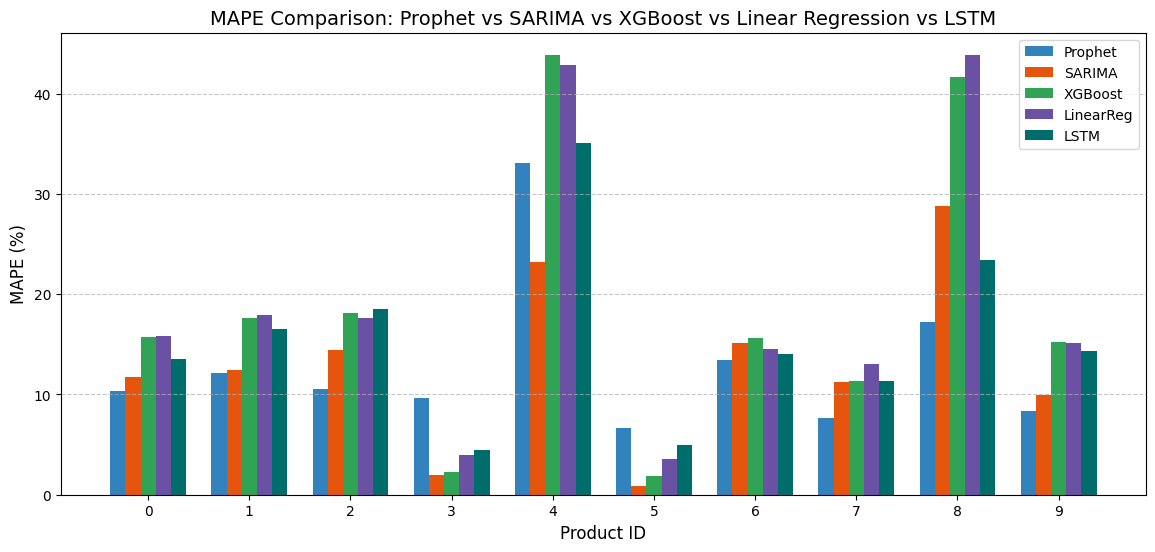

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Product IDs
products = list(range(10))

# MAPE values for the 5 models
prophet_mape = [10.35, 12.10, 10.56, 9.60, 33.10, 6.62, 13.41, 7.66, 17.20, 8.37]
sarima_mape  = [11.78, 12.45, 14.46, 1.98, 23.21, 0.84, 15.17, 11.26, 28.79, 9.95]
xgb_mape     = [15.69, 17.64, 18.11, 2.23, 43.89, 1.90, 15.67, 11.30, 41.63, 15.26]
lr_mape      = [15.84, 17.94, 17.59, 3.93, 42.86, 3.56, 14.52, 13.05, 43.83, 15.10]
lstm_mape    = [13.53, 16.49, 18.52, 4.48, 35.07, 4.91, 14.04, 11.34, 23.37, 14.31]

# Bar width
bar_width = 0.15
index = np.arange(len(products))

# Plot
plt.figure(figsize=(14,6))
plt.bar(index, prophet_mape, bar_width, label='Prophet', color='#3182bd')       
plt.bar(index + bar_width, sarima_mape, bar_width, label='SARIMA', color='#e6550d')  
plt.bar(index + 2*bar_width, xgb_mape, bar_width, label='XGBoost', color='#31a354')   
plt.bar(index + 3*bar_width, lr_mape, bar_width, label='LinearReg', color='#6a51a3')  
plt.bar(index + 4*bar_width, lstm_mape, bar_width, label='LSTM', color='#006d6d')     

# Labels & Titles
plt.xlabel('Product ID', fontsize=12)
plt.ylabel('MAPE (%)', fontsize=12)
plt.title('MAPE Comparison: Prophet vs SARIMA vs XGBoost vs Linear Regression vs LSTM', fontsize=14)
plt.xticks(index + 2*bar_width, products)  
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


<h1>Final Model Training

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
from pmdarima import auto_arima
from prophet import Prophet 

TARGET_COL = 'quantity'
product_ids = df['product_id_encoded'].unique()
df_full_history = pd.concat([df_train, df_validation, df_test]).copy()
final_models = {}

PROPHET_PRODUCTS = [0, 1, 2, 6, 7, 8, 9]
SARIMA_PRODUCTS = [3, 4, 5]

print("--- Training 10 Exact Champion Models (Prophet or SARIMA) ---")

for product_id_encoded in product_ids:
    
    # Aggregate data using the full available history
    daily_series_full = df_full_history[df_full_history['product_id_encoded'] == product_id_encoded][TARGET_COL].resample('D').sum().fillna(0)
    
    #  MODEL SELECTION 
    if product_id_encoded in PROPHET_PRODUCTS:
        # Use PROPHET
        df_prophet = daily_series_full.reset_index()
        df_prophet.columns = ['ds', 'y']
        model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
        model.fit(df_prophet)
        
    elif product_id_encoded in SARIMA_PRODUCTS:
        # Use SARIMA
        model = auto_arima(
            daily_series_full, 
            start_p=1, start_q=1, max_p=3, max_q=3, 
            m=7, seasonal=True, d=None, D=1, 
            trace=False, suppress_warnings=True, stepwise=True
        )
    
    final_models[product_id_encoded] = model
    print(f"Product {product_id_encoded}: Trained.")


#  CREATE FUTURE DATES 
last_date = df_full_history.index.max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=14, freq='D')

#  PREDICT, INVERSE TRANSFORM, AND AGGREGATE 
final_forecasts = []

for product_id_encoded, model in final_models.items():
    
    # Predict the scaled daily sum
    if product_id_encoded in PROPHET_PRODUCTS:
        n_periods = len(future_dates)
        future = model.make_future_dataframe(periods=n_periods, freq='D', include_history=False)
        forecast = model.predict(future)
        scaled_predictions = forecast['yhat'].values 
        
    elif product_id_encoded in SARIMA_PRODUCTS:
        n_periods = len(future_dates)
        scaled_predictions = model.predict(n_periods=n_periods).values 
    

    scaled_predictions_reshaped = scaled_predictions.reshape(-1, 1)
    real_unit_predictions = qty_scaler.inverse_transform(scaled_predictions_reshaped).flatten()
    
    real_unit_predictions = np.clip(real_unit_predictions, 1, None).round().astype(int)
    
    # Create the forecast DataFrame
    df_pred = pd.DataFrame({
        'sales_date': future_dates,
        'product_id_encoded': product_id_encoded,
        'quantity_predicted': real_unit_predictions
    }).set_index('sales_date')
    
    final_forecasts.append(df_pred)


df_final_forecast = pd.concat(final_forecasts).reset_index()

final_report_table = df_final_forecast.pivot(
    index='sales_date', 
    columns='product_id_encoded', 
    values='quantity_predicted'
)
final_report_table.columns = [f'Product {id}' for id in final_report_table.columns]
final_report_table.index = final_report_table.index.date

print("\n FINAL 14-DAY DAILY QUANTITY FORECAST ")
print(final_report_table.to_string())

13:02:29 - cmdstanpy - INFO - Chain [1] start processing
13:02:29 - cmdstanpy - INFO - Chain [1] done processing


--- Training 10 Exact Champion Models (Prophet or SARIMA) ---


13:02:29 - cmdstanpy - INFO - Chain [1] start processing
13:02:29 - cmdstanpy - INFO - Chain [1] done processing


Product 0: Trained.
Product 1: Trained.


13:02:29 - cmdstanpy - INFO - Chain [1] start processing
13:02:29 - cmdstanpy - INFO - Chain [1] done processing


Product 2: Trained.
Product 3: Trained.
Product 4: Trained.


13:03:30 - cmdstanpy - INFO - Chain [1] start processing


Product 5: Trained.


13:03:30 - cmdstanpy - INFO - Chain [1] done processing
13:03:30 - cmdstanpy - INFO - Chain [1] start processing


Product 6: Trained.


13:03:30 - cmdstanpy - INFO - Chain [1] done processing
13:03:30 - cmdstanpy - INFO - Chain [1] start processing


Product 7: Trained.


13:03:31 - cmdstanpy - INFO - Chain [1] done processing
13:03:31 - cmdstanpy - INFO - Chain [1] start processing


Product 8: Trained.


13:03:31 - cmdstanpy - INFO - Chain [1] done processing


Product 9: Trained.

 FINAL 14-DAY DAILY QUANTITY FORECAST 
            Product 0  Product 1  Product 2  Product 3  Product 4  Product 5  Product 6  Product 7  Product 8  Product 9
2025-12-01        554        378        583        866        214        867        459        746        208        585
2025-12-02        543        369        571        866        210        867        450        725        205        563
2025-12-03        557        377        577        858        183        862        469        751        207        580
2025-12-04        550        380        581        858        178        863        461        739        212        577
2025-12-05        554        381        571        863        160        868        464        737        210        578
2025-12-06        694        476        722        885        279        871        587        921        292        741
2025-12-07        695        479        726        884        276        871        588      

In [43]:
import pickle

with open("models/qty_scaler.pkl", "wb") as f:
    pickle.dump(qty_scaler, f)

In [44]:
PROPHET_PRODUCTS = [0, 1, 2, 6, 7, 8, 9]
SARIMA_PRODUCTS = [3, 4, 5]

for pid, model in final_models.items():
    if pid in PROPHET_PRODUCTS:
        with open(f'models/prophet_model_{pid}.pkl', 'wb') as f:
            pickle.dump(model, f)
        print(f"Prophet model for Product {pid} saved.")
        
    elif pid in SARIMA_PRODUCTS:
        with open(f'models/sarima_model_{pid}.pkl', 'wb') as f:
            pickle.dump(model, f)
        print(f"SARIMA model for Product {pid} saved.")


Prophet model for Product 0 saved.
Prophet model for Product 1 saved.
Prophet model for Product 2 saved.
SARIMA model for Product 3 saved.
SARIMA model for Product 4 saved.
SARIMA model for Product 5 saved.
Prophet model for Product 6 saved.
Prophet model for Product 7 saved.
Prophet model for Product 8 saved.
Prophet model for Product 9 saved.
